# Hallucination Score Analysis

In this notebook, the hallucination scores of the methods are analyzed.

In [34]:
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.preprocessing import binarize
from scipy.stats import chi2_contingency


## Utility Functions

In [35]:
# LOADING
# ______________
# load the dataframes and durations from the results folder
def load_dataframes(f):
    dataset_name = f.split("__")[0].split("_")[-4]
    model_name = f.split(dataset_name)[0].split("\\")[-1] +"_"+ f.split("__")[-1].split(".")[0]
    df = pd.read_csv(f)
    df.drop([col for col in df.columns if "answer" in col or "prompt" in col], axis=1, inplace=True)
    durations = f.split(dataset_name)[0] + "durations.csv"
    durations_df = pd.read_csv(durations) if len(glob.glob(durations)) > 0 else None
    return {"dataset_name": dataset_name, "model": model_name, "df": df, "durations": durations_df}


# PREPROCESSING
# ______________
# fix json errors in the column lbhd_score
def fix_json_errors(df):
    count = 0
    for index, row in df.iterrows():
        json_str = row['lbhd_score'].replace("'", "\"")
        while True:
            try:
                # Attempt to parse the JSON string
                json.loads(json_str)
                break  # Exit the loop if no error
            except json.JSONDecodeError as e:
                # If there's a JSONDecodeError, extract the position of the error
                error_pos = e.pos
                # print(f"Fixing error in row {index} at position: {error_pos}")
                # Add a backslash to the string in front of the error to escape the character
                json_str = json_str[:error_pos - 1] + "\\" + json_str[error_pos - 1:]
                # Replace the JSON string in the DataFrame with the corrected one
                df.at[index, 'lbhd_score'] = json_str
                count += 1
    print(f"Fixed {count} JSON errors\n")
    return df

# normalize the columns
def normalize_column(column):
    # Apply Min-Max normalization
    column = (column - column.min()) / (column.max() - column.min())
    # rescale to [0, 1] range (from [-1, 1] range)
    column = (column + 1) / 2
    return column

# process the lbhd_score column
def process_lbhd_scores(df):
    # Initialize new columns with default values
    df['lbhd_sent_avg'] = 0.0
    df['lbhd_sent_min'] = 0.0
    df['lbhd_sent_normalized_product'] = 0.0
    df['lbhd_concept_avg'] = 0.0
    df['lbhd_concept_min'] = 0.0
    df['lbhd_concept_normalized_product'] = 0.0
    # Iterate over each row to process the 'lbhd_score' column
    for index, row in df.iterrows():
        # Parse the string representation of the dictionary into an actual dictionary
        lbhd_score = json.loads(row['lbhd_score'].replace("'", "\""))        
        # Extract the low-level scores
        df.at[index, 'lbhd_sent_avg'] = lbhd_score['avg']
        df.at[index, 'lbhd_sent_min'] = lbhd_score['min']
        df.at[index, 'lbhd_sent_normalized_product'] = lbhd_score['normalized_product']        
        # Aggregate the concept-level scores
        concept_avgs = [concept[next(iter(concept))]['avg'] for concept in lbhd_score['concepts']]
        concept_mins = [concept[next(iter(concept))]['min'] for concept in lbhd_score['concepts']]
        concept_norm_prods = [concept[next(iter(concept))]['normalized_product'] for concept in lbhd_score['concepts']]        
        df.at[index, 'lbhd_concept_avg'] = np.mean(concept_avgs)
        df.at[index, 'lbhd_concept_min'] = np.min(concept_mins)
        def normalized_product(probabilities):
            adjusted_probs = [max(p, 1e-30) for p in probabilities]
            log_probs = np.log(adjusted_probs)
            score = np.exp(np.sum(log_probs) / len(adjusted_probs))
            return score
        df.at[index, 'lbhd_concept_normalized_product'] = normalized_product(concept_norm_prods)
    # Remove the 'lbhd_score' column
    df.drop('lbhd_score', axis=1, inplace=True)
    # Normalize the new columns
    df['lbhd_sent_avg'] = normalize_column(df['lbhd_sent_avg'])
    df['lbhd_sent_min'] = normalize_column(df['lbhd_sent_min'])
    df['lbhd_sent_normalized_product'] = normalize_column(df['lbhd_sent_normalized_product'])
    df['lbhd_concept_avg'] = normalize_column(df['lbhd_concept_avg'])
    df['lbhd_concept_min'] = normalize_column(df['lbhd_concept_min'])
    df['lbhd_concept_normalized_product'] = normalize_column(df['lbhd_concept_normalized_product'])
    # reverse calculation of: linear_probs = [(prob + 1) / 2 for prob in linear_probs]
    for col in df.columns:
        if "lbhd" in col:
            df[col] = (df[col] * 2) - 1
    return df

# Remove rows with errors
def remove_err_rows(df):
    initial_rows = len(df)
    print(f"Initial rows: {initial_rows}")
    df = df.dropna()
    # if objects, means its a string representation of a dictionary
    for col in df.columns:
        if df[col].dtype == "object":
            # remove if 'error' is first key
            df = df[~df[col].str.contains("error")]
            if len(df) < initial_rows:
                print(f"Removed {initial_rows - len(df)} rows with errors in column {col}")
            initial_rows = len(df)  # update initial_rows for the next iteration
        elif df[col].dtype == "float64":
            # remove if -1
            df = df[df[col] != -1]
            if len(df) < initial_rows:
                print(f"Removed {initial_rows - len(df)} rows with errors in column {col}")
            initial_rows = len(df)  # update initial_rows for the next iteration
    print(f"Final rows: {initial_rows}")
    return df


# EVALUATION
# ______________
# calculate the metrics (AUC-ROC, AUC-PR, Precision, Recall, F1) for each column
def calculate_metrics(df):
    metrics = {}
    for column in df.columns:
        ground_truth = df['ground_truth'].values
        score = df[column].values
        # Calculate AUC-ROC
        auc_roc = roc_auc_score(ground_truth, score)
        # Calculate AUC-PR
        auc_pr = average_precision_score(ground_truth, score)
        precision, recall, thresholds = precision_recall_curve(ground_truth, score)
        threshold = thresholds[np.argmax(2 * precision * recall / (precision + recall))]
        # Binarize the scores using the threshold
        binarized_score = binarize(score.reshape(1, -1), threshold=threshold).flatten()
        # Calculate Precision, Recall, F1
        precision = precision_score(ground_truth, binarized_score)
        recall = recall_score(ground_truth, binarized_score)
        f1 = f1_score(ground_truth, binarized_score)
        # Calculate Precision, Recall, F1, and F2 scores
        metrics[column] = {"AUC-ROC": auc_roc, "AUC-PR": auc_pr, "Precision": precision, "Recall": recall, "F1": f1}
    return metrics


# VISUALIZATION
# ______________
# plot the correlation matrix
def plot_correlation_matrix(df, model_name, dataset_name):
    # Ensure 'ground_truth' is the last column
    columns = [col for col in df.columns if col != 'ground_truth'] + ['ground_truth']
    df = df[columns]
    # Compute the correlation matrix
    corr = df.corr()
    # Identify the 3 strongest correlations with 'ground_truth' by absolute value, excluding itself
    strongest_corr = corr['ground_truth'].drop('ground_truth').abs().nlargest(3).index.tolist()
    fig, ax = plt.subplots(figsize=(11, 9))
    cmap = "YlGnBu"
    # Draw the heatmap with the correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot=True, fmt=".2f", annot_kws={"size": 7},
                mask=np.triu(np.ones_like(corr, dtype=bool)))  # Mask for the upper triangle
    # Highlight the columns and rows of the 3 strongest correlations
    for strong_corr in strongest_corr:
        if not np.tril(np.ones_like(corr, dtype=bool))[df.columns.get_loc(strong_corr), len(df.columns) - 1]:
            ax.add_patch(Rectangle((df.columns.get_loc(strong_corr), len(df.columns) - 1), 1, 1, fill=False, edgecolor='red', lw=3))
        if not np.tril(np.ones_like(corr, dtype=bool))[len(df.columns) - 1, df.columns.get_loc(strong_corr)]:
            ax.add_patch(Rectangle((len(df.columns) - 1, df.columns.get_loc(strong_corr)), 1, 1, fill=False, edgecolor='red', lw=3))
    ax.set_xticks(np.arange(len(corr.columns)) + .5)
    ax.set_yticks(np.arange(len(corr.columns)) + .5)
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticklabels(corr.columns)
    # Set title with model and dataset names
    dataset_name = "Natural Questions" if dataset_name == "nqopen" else "XSum" if dataset_name == "xsum" else dataset_name
    plt.title(f'Correlation Matrix for {model_name}\non dataset {dataset_name} with Highlights', fontsize=16, pad=20)
    # Adjust layout to fit everything
    plt.tight_layout()
    # Display the plot
    plt.show()

def plot_categorical(df):
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if 'ground_truth' in cat_cols:
        for col in cat_cols:
            if col != 'ground_truth':
                tab = pd.crosstab(df[col], df['ground_truth'])
                chi2, p, dof, ex = chi2_contingency(tab)
                if p < 0.01:
                    plt.figure(figsize=(10, 6))
                    sns.barplot(x=tab.index, y=tab['ground_truth'], data=tab)
                    plt.title(f'{col} vs ground_truth (Chisq P = {p:.2e})')
                    plt.xlabel(f'{col}')
                    plt.ylabel('Proportion')
                    plt.xticks(rotation=90)
                    plt.show()
    else:
        print("There is no 'ground_truth' categorical variable")


## Loading the scores

In [36]:
# load datasets
# find all csvs with scores and ground truths
files = glob.glob("results/*with_ground_truths*.csv")

# load all csvs into a list of dataframes
datasets = [load_dataframes(f) for f in files]

print(f"Found {len(datasets)} CSVs with scores and ground truths for analysis:\n")
for dataset in datasets:
    print(f"Dataset: {dataset['dataset_name']}")
    print(f"LLM: {dataset['model']}")
    print(f"Shape: {dataset['df'].shape}\n")

Found 6 CSVs with scores and ground truths for analysis:

Dataset: nqopen
LLM: openai__gpt-3-5-turbo
Shape: (80, 6)

Dataset: xsum
LLM: openai__gpt-3-5-turbo
Shape: (80, 6)

Dataset: nqopen
LLM: togetherai_2__mistralai_Mistral-7B-Instruct-v0-1
Shape: (80, 6)

Dataset: xsum
LLM: togetherai_2__mistralai_Mistral-7B-Instruct-v0-1
Shape: (80, 6)

Dataset: nqopen
LLM: togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1
Shape: (80, 6)

Dataset: xsum
LLM: togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1
Shape: (80, 6)



In [37]:
test_df = datasets[0]["df"]
test_df.head(2)

,fleek_score,selfcheck_nli_score,selfcheck_bert_score,lm_v_lm_score,lbhd_score,ground_truth
0,0.0,0.049175,0.167182,0.0,"{'avg': 0.9644255675958286, 'normalized_produc...",0.0
1,0.0,0.992679,0.348210,0.0,"{'avg': 0.9406606117559376, 'normalized_produc...",0.0


In [38]:
# remove rows with errors
test_df = remove_err_rows(test_df)

Initial rows: 80
Removed 7 rows with errors in column fleek_score
Final rows: 73


In [39]:
# process LBHD scores
test_df = fix_json_errors(test_df)
test_df = process_lbhd_scores(test_df)   # aggregate concept-level scores and normalize (min-max)
test_df.head(10)

Fixed 10 JSON errors



,fleek_score,selfcheck_nli_score,selfcheck_bert_score,lm_v_lm_score,ground_truth,lbhd_sent_avg,lbhd_sent_min,lbhd_sent_normalized_product,lbhd_concept_avg,lbhd_concept_min,lbhd_concept_normalized_product
0,0.0,0.049175,0.167182,0.0,0.0,0.790905,0.773267,0.838525,0.906200,0.761935,0.923568
1,0.0,0.992679,0.348210,0.0,0.0,0.646000,0.371723,0.672972,0.844038,0.832743,0.878414
2,0.0,0.002411,0.260011,0.0,0.0,0.766949,0.667007,0.811579,0.933477,0.860099,0.948059
3,0.0,0.002031,0.260233,0.0,1.0,0.713788,0.765373,0.777995,0.821975,0.754156,0.854498
4,1.0,0.200661,0.416712,0.0,1.0,0.447602,0.437369,0.537830,0.575326,0.430959,0.626153
6,0.0,0.004102,0.398616,0.0,1.0,0.685778,0.589252,0.743162,0.796285,0.580616,0.817105
7,0.0,0.001529,0.263676,0.0,0.0,0.651613,0.314664,0.647074,0.668460,0.310053,0.642534
9,0.0,0.001360,0.192370,0.0,0.0,0.903768,0.725936,0.920954,0.997503,0.996834,0.998147
10,0.0,0.000960,0.336033,0.0,0.0,0.947292,0.942919,0.961283,0.942284,0.929100,0.956291
11,1.0,0.798838,0.657263,0.0,0.0,0.386247,0.241743,0.415992,0.695506,0.512687,0.735285


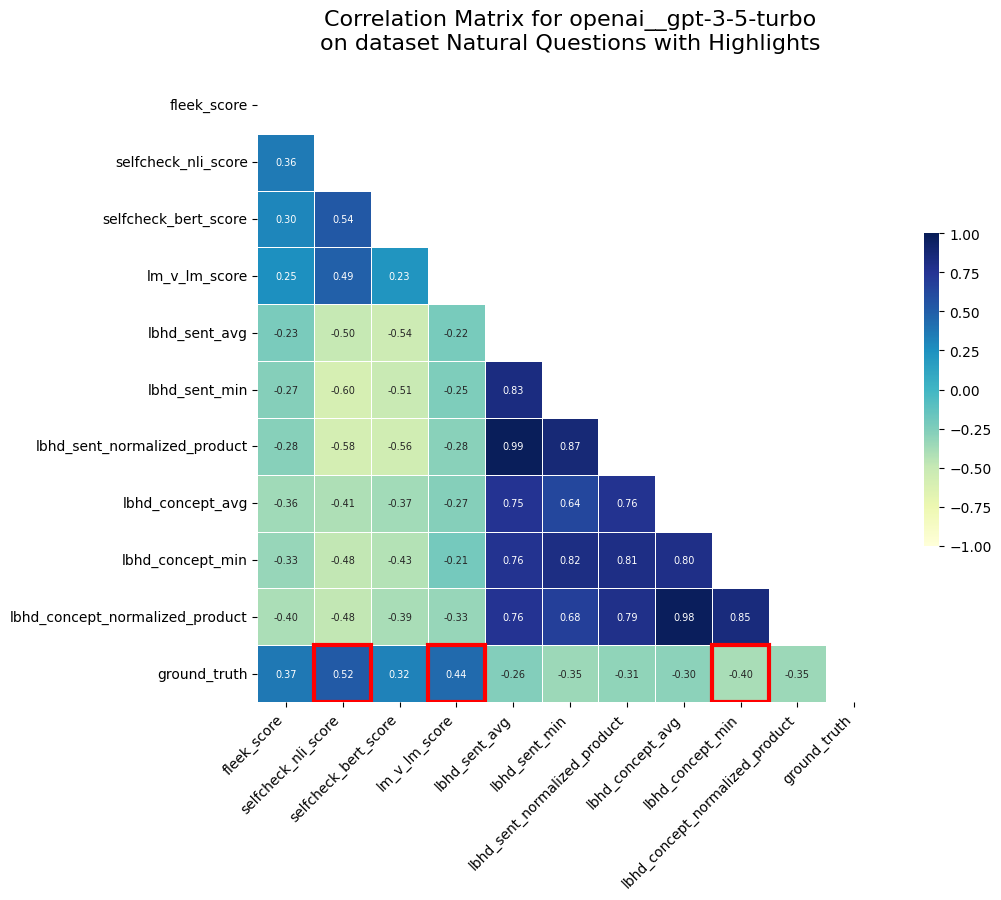

In [40]:
plot_correlation_matrix(test_df, datasets[0]["model"], datasets[0]["dataset_name"])

In [46]:
# Calculate metrics for the 'lbhd_concept_min' column
metrics = calculate_metrics(test_df)
columns = test_df.columns
print(f"Metrics for {datasets[0]['model']} on {datasets[0]['dataset_name']}:\n")
for column in columns:
    print(f"Column: {column}")
    print(f"Precision: {metrics[column]['Precision']}")
    print(f"Recall: {metrics[column]['Recall']}")
    print(f"F1: {metrics[column]['F1']}")
    print(f"AUC-ROC: {metrics[column]['AUC-ROC']}")
    print(f"AUC-PR: {metrics[column]['AUC-PR']}\n")

Metrics for openai__gpt-3-5-turbo on nqopen:

Column: fleek_score
Precision: 0.0
Recall: 0.0
F1: 0.0
AUC-ROC: 0.6807692307692309
AUC-PR: 0.3266596417281349

Column: selfcheck_nli_score
Precision: 0.5714285714285714
Recall: 0.6153846153846154
F1: 0.5925925925925926
AUC-ROC: 0.858974358974359
AUC-PR: 0.6340291576555313

Column: selfcheck_bert_score
Precision: 0.0
Recall: 0.0
F1: 0.0
AUC-ROC: 0.767948717948718
AUC-PR: 0.382956363612616

Column: lm_v_lm_score
Precision: 0.0
Recall: 0.0
F1: 0.0
AUC-ROC: 0.6923076923076924
AUC-PR: 0.4035827186512118

Column: ground_truth
Precision: 0.0
Recall: 0.0
F1: 0.0
AUC-ROC: 1.0
AUC-PR: 1.0

Column: lbhd_sent_avg
Precision: 0.0
Recall: 0.0
F1: 0.0
AUC-ROC: 0.30641025641025643
AUC-PR: 0.13213151082504326

Column: lbhd_sent_min
Precision: 0.0
Recall: 0.0
F1: 0.0
AUC-ROC: 0.2730769230769231
AUC-PR: 0.12804919749930174

Column: lbhd_sent_normalized_product
Precision: 0.0
Recall: 0.0
F1: 0.0
AUC-ROC: 0.29102564102564105
AUC-PR: 0.13011388304980437

Column: 

c:\Users\sbene\miniconda3\envs\hdetect\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sbene\AppData\Local\Temp\ipykernel_16920\915867862.py:126: RuntimeWarning: invalid value encountered in divide
  threshold = thresholds[np.argmax(2 * precision * recall / (precision + recall))]
c:\Users\sbene\miniconda3\envs\hdetect\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sbene\miniconda3\envs\hdetect\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-define

<Axes: xlabel='lbhd_concept_min', ylabel='Count'>

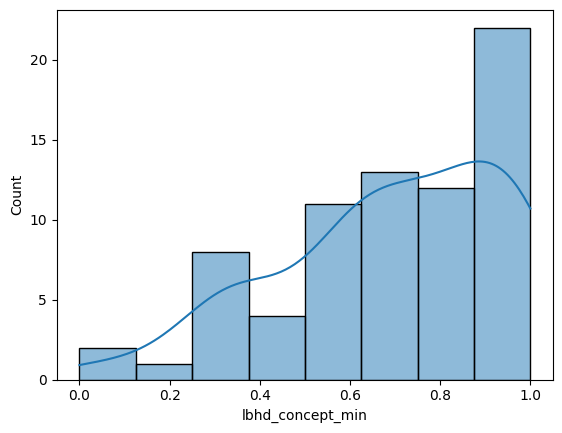

In [42]:
# look at lbhf_concept_min: distribution of scores
sns.histplot(test_df['lbhd_concept_min'], kde=True)

In [43]:
plot_categorical(test_df)

There is no 'ground_truth' categorical variable
